In [2]:
# Import library
from numpy import loadtxt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
scaler = MinMaxScaler()

from xgboost import XGBClassifier

from sklearn.model_selection import LeaveOneGroupOut, GroupShuffleSplit,GridSearchCV,\
    cross_val_score, cross_val_predict, ShuffleSplit,learning_curve, train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc,fbeta_score,\
    make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

# Load the data
subj_cond = pd.read_table('../Build_DB/subj_cond3.txt', delimiter=",") # unique subjects and their condition
df1 = pd.read_table('../Build_DB/dataframe_stress3.txt', delimiter=",") # dataframe stress
# shuffle datasets
df = df1.sample(frac=1, random_state=1).reset_index(drop=False) 

bad_subj = {41, 42,55, 59, 60, 61, 66, 71, 82,87,90,91,97,98,100,114, 115,121,129,130,131,134,136,138, 147,149,
            153, 154,159,163,171, 170, 173,174,
            35,67,69,77,79,83,85,86,139,146,161,166,
            125} # 3rd line:bad sub in control group ph1, subj 125 not stressed

df_good = df[~df['Subject'].isin(bad_subj)]

# data of first stress phase  
ds = df_good[((df_good.S == 0) & (df_good.Condition == 0))|((df_good.S ==1)&(df_good.Condition ==1))] 

# remove outliers of features values    
ds0 = ds[ds.S == 0]
ds1 = ds[ds.S == 1]
ds_droped0 = ds0.mask((ds0 - ds0.mean()).abs() > 3.5 * ds0.std()).dropna()
ds_droped1 = ds1.mask((ds1 - ds1.mean()).abs() > 3.5 * ds1.std()).dropna()
ds_droped = pd.concat([ds_droped0,ds_droped1])
X = ds_droped.iloc[:, 1:-3] # samples
S =  ds_droped['S'] # stress labels, S=1 stress, S= 0 control
Subject =  ds_droped['Subject']
# condition = 1 means stress then control, condition=0 means control then stress
Condition =  ds_droped['Condition'] 

print("Orig DataFrame: {}" .format(df.shape) )
print("\n")
print("first phase DataFrame: {}" .format(ds.shape) )
print("\n")
print("Removed outliers dataframe: {}".format(ds_droped.shape) )
print("\n")
print("(Samples, Features): {}".format(X.shape) )

Orig DataFrame: (1983, 70)


first phase DataFrame: (546, 70)


Removed outliers dataframe: (415, 70)


(Samples, Features): (415, 66)


In [3]:
modelxgb = XGBClassifier()
good_subj = Subject.unique()
good_subj.sort()
logo = LeaveOneGroupOut()
number_groups = logo.get_n_splits(X, S, Subject)

In [5]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=.33, n_splits=2, random_state = 14).split(X, S, groups=Subject))
X_train, X_test = X.iloc[train_inds,:], X.iloc[test_inds,:]
y_train, y_test = S.iloc[train_inds], S.iloc[test_inds]
print(' shape training set: {}' .format(X_train.shape))
print(' shape test set: {}' .format(X_test.shape))
dtr = pd.DataFrame(X_train, y_train) # training data frame
dts = pd.DataFrame(X_test, y_test) # test dataframe
print('check balance in train samples: {}' .format(dtr.groupby('S').size()))
print('check balance in test samples: {}' .format(dts.groupby('S').size()))
train_subject = Subject.iloc[train_inds].unique()
test_subject = Subject.iloc[test_inds].unique()
train_subjects = Subject.iloc[train_inds]
test_subjects = Subject.iloc[test_inds]
print('number subject train: {}' .format(train_subject.shape))
print('number subject test: {}' .format(test_subject.shape))

subj_cond_tr = subj_cond[subj_cond['sub'].isin(train_subject)]
subj_cond_ts = subj_cond[subj_cond['sub'].isin(test_subject)]
print('check balance in train subjects: {}' .format(subj_cond_tr.groupby('cond').size()))
print('check balance in test subjects: {}' .format(subj_cond_ts.groupby('cond').size()))
test_subject.sort()

train_subject.sort()

 shape training set: (282, 66)
 shape test set: (133, 66)
check balance in train samples: S
0    153
1    129
dtype: int64
check balance in test samples: S
0    95
1    38
dtype: int64
number subject train: (40,)
number subject test: (20,)
check balance in train subjects: cond
0    23
1    17
dtype: int64
check balance in test subjects: cond
0    14
1     6
dtype: int64


In [4]:
cv = GroupShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
final_features = []
final_features.insert(0, ['ECG_RR_mean' ,'ECG_RR_SDNN' ,'ECG_RR_SDSD', 'ECG_RR_L' ,'ECG_RR_L2',
 'ECG_RR_LoT_2', 'ECG_RR_Log10LT_2', 'RSP_RATE_std', 'RSP_Pk', 'RSP_HF',
 'RSP_HF_gaussF1', 'RSP_ecgHF_pF2n' ,'PPG_PP_CSI_modified', 'PPG_PRT_SDNN',
 'SCL_mean', 'SCL_std'])

final_features.insert(1,['ECG_RR_mean', 'ECG_RR_SDNN', 'ECG_RR_SDSD', 'ECG_RR_L2', 'RSP_HF',
 'RSP_ecgHF_pF2n', 'SCL_mean'])

final_features.insert(2,['ECG_RR_mean', 'ECG_RR_SDSD', 'ECG_RR_PNN50', 'ECG_RR_L', 'ECG_RR_CVI',
 'ECG_RR_LoT_2', 'SCL_mean', 'SCL_gradient'])

final_features.insert(3,['ECG_RR_mean', 'ECG_RR_SDNN', 'ECG_RR_SDSD', 'ECG_RR_PNN50', 'ECG_RR_L2',
 'ECG_RR_LoT_2'])
# final_features.insert(3,['ECG_RR_mean'])

final_features.insert(4,['SCL_mean'])


In [18]:
from imblearn.metrics import geometric_mean_score, sensitivity_score,specificity_score
step_plusone = 5

for j in range(step_plusone):
    print(j)
    feat_list = final_features[j]
    X_tr = X_train[feat_list]
    modelxgbb= XGBClassifier()
    f1s = []
    ps =[]
    rs =[]
    accs = []
    gms =[]
    spes =[]
    sens = []
    for i, (train_index, val_index) in enumerate(cv.split(X_tr, y_train, train_subjects)):
        X_train_tr, X_val = X_tr.iloc[train_index,:], X_tr.iloc[val_index,:]
        y_train_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        modelxgbb.fit(X_train_tr, y_train_tr)
        y_proba = modelxgbb.predict_proba(X_val)[:, 1]
        y_pred = modelxgbb.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        f1 = fbeta_score(y_val, y_pred, beta=1)
        p = precision_score(y_val, y_pred)
        r = recall_score(y_val, y_pred)
        
        gm = geometric_mean_score(y_val, y_pred)
        spe = specificity_score(y_val, y_pred)
        sen = sensitivity_score(y_val, y_pred)
    
        accs.append(acc)
        f1s.append(f1)
        ps.append(p)
        rs.append(r)
        gms.append(gm)
        spes.append(spe)
        sens.append(sen)
    mean_f1 = np.mean(f1s, axis =0)
    mean_p = np.mean(ps, axis =0)
    mean_r = np.mean(rs, axis =0)
    mean_acc = np.mean(accs, axis =0)
    mean_gm = np.mean(gms, axis =0)
    mean_spe = np.mean(spes, axis =0)
    mean_sen = np.mean(sens, axis =0)
    
    # std_f1 = np.std(f1s, axis =0)
    # std_p = np.std(ps, axis =0)
    # std_r = np.std(rs, axis =0)
    # std_acc = np.std(accs, axis =0)

    print('CV Accuracy: ',mean_acc)
    print('CV F1: ',mean_f1)
    print('CV Precision: ',mean_p)
    print('CV Recall: ',mean_r)
    
    print('CV Gmean: ',mean_gm)
    print('CV Specificity: ',mean_spe)
    print('CV Sensitivity: ',mean_sen)
    print("\n")
    print("\n")

0
CV Accuracy:  0.9019548658923412
CV F1:  0.8680714062690955
CV Precision:  0.8835732170020094
CV Recall:  0.8743699633699634
CV Gmean:  0.899909890341814
CV Specificity:  0.9355942942653745
CV Sensitivity:  0.8743699633699634




1
CV Accuracy:  0.8863468804113974
CV F1:  0.8517617519851879
CV Precision:  0.840301233624763
CV Recall:  0.89663597322218
CV Gmean:  0.888773677868478
CV Specificity:  0.8933529880615548
CV Sensitivity:  0.89663597322218




2
CV Accuracy:  0.885450288577703
CV F1:  0.8518638869004675
CV Precision:  0.8561608913487848
CV Recall:  0.86603663003663
CV Gmean:  0.8845666288618533
CV Specificity:  0.9122895894689453
CV Sensitivity:  0.86603663003663




3
CV Accuracy:  0.8743804619113018
CV F1:  0.8365345928670495
CV Precision:  0.8219618226464327
CV Recall:  0.8817435897435898
CV Gmean:  0.8802963564895249
CV Specificity:  0.886973614598119
CV Sensitivity:  0.8817435897435898




4
CV Accuracy:  0.5665567687439798
CV F1:  0.4953333426884596
CV Precision:  0.46

In [19]:
step_plusone =5
tes_acc = np.ones(step_plusone)
tes_f1 = np.ones(step_plusone)
tes_p = np.ones(step_plusone)
tes_r = np.ones(step_plusone)
tes_gm = np.ones(step_plusone)
tes_spe = np.ones(step_plusone)
tes_sen = np.ones(step_plusone)
for j in range(step_plusone):
    print(j)
    feat_list = final_features[j]
    X_tr = X_train[feat_list]
    X_te = X_test[feat_list]
    model = XGBClassifier().fit(X_tr, y_train)
    print('Acc training set: {:.4f}'
         .format(model.score(X_tr, y_train)))
    y_pred = model.predict(X_te)
    tes_acc[j] = accuracy_score(y_test, y_pred)
    tes_f1[j] = fbeta_score(y_test, y_pred, beta=1)
    tes_p[j] = precision_score(y_test, y_pred)
    tes_r[j] = recall_score(y_test, y_pred)
    tes_gm[j] = geometric_mean_score(y_test, y_pred)
    tes_spe[j] = specificity_score(y_test, y_pred)
    tes_sen[j] = sensitivity_score(y_test, y_pred)
    print('test Accuracy: ',tes_acc[j])
    print('test F1: ',tes_f1[j])
    print('test Precision: ',tes_p[j])
    print('test Recall: ',tes_r[j])
    print('test Gmean: ',tes_gm[j])
    print('test Specificity: ',tes_spe[j])
    print('test Sensitivity: ',tes_sen[j])
    print("\n")
    print("\n")

0
Acc training set: 1.0000
test Accuracy:  0.8872180451127819
test F1:  0.8
test Precision:  0.8108108108108109
test Recall:  0.7894736842105263
test Gmean:  0.855161937330101
test Specificity:  0.9263157894736842
test Sensitivity:  0.7894736842105263




1
Acc training set: 1.0000
test Accuracy:  0.8571428571428571
test F1:  0.7466666666666667
test Precision:  0.7567567567567568
test Recall:  0.7368421052631579
test Gmean:  0.8167227259482451
test Specificity:  0.9052631578947369
test Sensitivity:  0.7368421052631579




2
Acc training set: 1.0000
test Accuracy:  0.8721804511278195
test F1:  0.7792207792207793
test Precision:  0.7692307692307693
test Recall:  0.7894736842105263
test Gmean:  0.8453883370636321
test Specificity:  0.9052631578947369
test Sensitivity:  0.7894736842105263




3
Acc training set: 0.9965
test Accuracy:  0.7744360902255639
test F1:  0.6808510638297872
test Precision:  0.5714285714285714
test Recall:  0.8421052631578947
test Gmean:  0.7933239444807062
test Spe

In [5]:
from sklearn.model_selection import GridSearchCV

n_depths_range = np.linspace(1, 10, 10).astype('int')
n_estimators_range = np.linspace(1, 100, 100).astype('int')

step_plusone = 5
max_depths =np.ones(step_plusone)
max_trees =np.ones(step_plusone)
max_cvs =np.ones(step_plusone)

for j in range(step_plusone):
    print(j)
    feat_list = final_features[j]
    X_tr = X_train[feat_list]
    params = {
        'max_depth': n_depths_range, 
        'n_estimators': n_estimators_range, 
         }
    xgb_gscv = GridSearchCV(modelxgb, param_grid = params, scoring = "accuracy",
                                 cv = cv )
    # Fit the model
    model_xgboost = xgb_gscv.fit(X_tr, y_train,groups=train_subjects)

    # Model best estimator
    max_depths[j]=model_xgboost.best_estimator_.get_params()["max_depth"]
    max_trees[j]= model_xgboost.best_estimator_.get_params()["n_estimators"]
    max_cvs[j]= xgb_gscv.best_score_
    print("Max Depth: ", max_depths[j])
    print("Max Trees: ",max_trees[j])
    print("Max CV: ",max_cvs[j])

0
Max Depth:  6.0
Max Trees:  41.0
Max CV:  0.909324710381861
1
Max Depth:  3.0
Max Trees:  56.0
Max CV:  0.9044217732465037
2
Max Depth:  5.0
Max Trees:  1.0
Max CV:  0.8948693996654924
3
Max Depth:  1.0
Max Trees:  1.0
Max CV:  0.8879877005402426
4
Max Depth:  6.0
Max Trees:  1.0
Max CV:  0.6467921138279051


In [6]:
import shap
features = np.array(X_train.columns)
max_depths = max_depths.astype(np.int64)
max_trees = max_trees.astype(np.int64)
rem_feat3 =[]

e_ecg = np.array([[0.0006, 0.0013, 0.0009, 0, 0.001, 0.0008, 0.0019, 0.002, 0.0044,
                   0.0008, 0.0018, 0.0045, 0.0906, 0.0906, 0.0906, 0.1813]])
e_rsp = np.array([[0.0001, 0.0005, 0.0001, 0.0001, 0.0001, 0.0109, 0.0109, 0.0109,
                   0.0563, 0.0071, 0.0337, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004]])
e_ppg =  np.array([[0.0006, 0.0013, 0.0009, 0, 0.001, 0.0008, 0.0019, 0.002, 0.0044,
                    0.0008, 0.0018, 0.0045, 0.0906, 0.0906, 0.0906, 0.1813, 0.0006,
                    0.0013, 0.0009, 0.0906, 0.0906, 0.0906, 0.1813, 0.0006, 0.0013,
                    0.00096, 0.0006, 0.0013, 0.0009]]) 
e_eda =  np.array([[0.02, 0.04, 0.02, 0.07, 0.07]]) 

# energy sensors, pre-processing, and filtering
es_ecg =  np.array([[6.76 ]]) 
es_rsp =  np.array([[11.1566]]) 
es_ppg =  np.array([[18.452]]) 
es_eda =  np.array([[3.2]]) 

# energy parameters
ePoin_ecg =  np.array([[0.0453]]) 
ePsd_ecg =  np.array([[0.09341]]) # old 166.14
eDel_rsp =  np.array([[0.7535]]) 
ePk_rsp =  np.array([[3.784]]) 
ePsd_rsp =  np.array([[3.7381]])
ePoin_ppg =  np.array([[0.0453]])
ePsd_ppg =  np.array([[0.09511]]) #166.14
eScl_eda =  np.array([[0.64]])

a0 = np.concatenate((e_ecg, e_rsp, e_ppg, e_eda, es_ecg, es_rsp, es_ppg, es_eda,
                     ePoin_ecg, ePsd_ecg, eDel_rsp,ePk_rsp, ePsd_rsp, ePoin_ppg,
                     ePsd_ppg, ePsd_ppg, eScl_eda), axis=1)

total_energy = np.sum(a0)

step_plusone = 5
final_features2 =[]
for j in range(step_plusone):
    print(j)
    feat_list = final_features[j]
    X_tr = X_train[feat_list]
    params = {
        'max_depth': max_depths[j], 
        'n_estimators': max_trees[j], 
         }
    modelxgb3= XGBClassifier(**params)
    nsf = X_tr.shape[1] 
    # RFECV with SHAP features importances
    remaining_features3 = feat_list.copy()
    acc_mean2 = np.ones(nsf)
    acc_std2 = np.ones(nsf)
    for i in range(nsf): 
        modelxgb3.fit(X_tr, y_train)
        
        acc_xgb2 = cross_val_score(modelxgb3, X_tr, y_train, groups=train_subjects, cv=cv)
        acc_mean2[nsf-(i+1)] = acc_xgb2.mean()
        acc_std2[nsf-(i+1)] = acc_xgb2.std()
        
        shap_values3 = shap.TreeExplainer(modelxgb3).shap_values(X_tr)
        global_shap_values3 = np.abs(shap_values3).mean(0)
        sort_inds3 = np.argsort(global_shap_values3)
        
        removed_feature3 = remaining_features3[sort_inds3[0]]
        X_tr = X_tr.drop(removed_feature3, axis=1)
        rem_feat3.insert(i,[remaining_features3])
        remaining_features3 = np.delete(remaining_features3, sort_inds3[0],0)
        
    maximum_score = np.amax(acc_mean2)
    max_acc = 'Max CV Acc. selected feat is: %.4f'% maximum_score
    print(max_acc)    
    result_ind3 = np.where(acc_mean2 == np.amax(acc_mean2))
    selected_features3=rem_feat3[nsf-result_ind3[0][0]-1][0]
    final_features2.insert(j, [selected_features3])
    
    number_selected_features2 = np.where(acc_mean2 == np.amax(acc_mean2))[0][0]+1


    L= []
    for h, u in enumerate(selected_features3): 
        res_ind = np.where(features == u)
        L.append(res_ind[0][0])
    cost2 = np.sum(np.take(a0, L))  
    if any(y < 16 for y in L):
        cost2 = cost2+ 6.76
    if any(4< y < 12 for y in L):
        cost2 = cost2+ 0.04532
    if any(11< y < 16 for y in L):
        cost2 = cost2+ 0.09341   
    if any(15< y < 32 for y in L):
        cost2 = cost2+ 11.1566
    if any(15< y < 18 for y in L):
        cost2 = cost2+ 0.7533
    if any(17< y < 21 for y in L):
        cost2 = cost2 + 3.784
    if any(20< y < 32 for y in L):
        cost2 = cost2+ 3.7381        
    if any(31< y < 61 for y in L):
        cost2 = cost2+ 18.452
    if any(36< y < 44 for y in L):
        cost2 = cost2 + 0.04532
    if any(43< y < 48 for y in L):
        cost2 = cost2+ 0.09511 
    if any(50< y < 55 for y in L):
        cost2 = cost2+ 0.09511 
    if any(60< y < 66 for y in L):
        cost2 = cost2+ 3.2
    if any(60< y < 65 for y in L):
        cost2 = cost2+ 0.64
    
    our_cost = " max selected need "+str(cost2)+" mj energy."
    print(our_cost)
    print(selected_features3)
    print("\n")

0
Max CV Acc. selected feat is: 0.9093
 max selected need 48.66764 mj energy.
['ECG_RR_mean', 'ECG_RR_SDNN', 'ECG_RR_SDSD', 'ECG_RR_L', 'ECG_RR_L2', 'ECG_RR_LoT_2', 'ECG_RR_Log10LT_2', 'RSP_RATE_std', 'RSP_Pk', 'RSP_HF', 'RSP_HF_gaussF1', 'RSP_ecgHF_pF2n', 'PPG_PP_CSI_modified', 'PPG_PRT_SDNN', 'SCL_mean', 'SCL_std']


1
Max CV Acc. selected feat is: 0.9044
 max selected need 25.57492 mj energy.
['ECG_RR_mean', 'ECG_RR_SDNN', 'ECG_RR_SDSD', 'ECG_RR_L2', 'RSP_HF', 'RSP_ecgHF_pF2n', 'SCL_mean']


2
Max CV Acc. selected feat is: 0.8949
 max selected need 10.69482 mj energy.
['ECG_RR_mean', 'ECG_RR_SDSD', 'ECG_RR_PNN50', 'ECG_RR_L', 'ECG_RR_CVI', 'ECG_RR_LoT_2', 'SCL_mean', 'SCL_gradient']


3
Max CV Acc. selected feat is: 0.8880
 max selected need 6.7606 mj energy.
['ECG_RR_mean']


4
Max CV Acc. selected feat is: 0.6468
 max selected need 3.8600000000000003 mj energy.
['SCL_mean']




Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.
Setting feature_perturbation = "tree_path_dependent" because no background data was given.

In [23]:
max_depths = np.array([6,3,5,1,6])
max_trees = np.array([41,56,1,1,1])
for j in range(step_plusone):
    print(j)
    feat_list = final_features2[j][0]
    X_tr = X_train[feat_list]
    params = {
    'max_depth': max_depths[j], 
    'n_estimators': max_trees[j]
     }
    modelxgbb = XGBClassifier(**params).fit(X_tr, y_train)
    f1s = []
    ps =[]
    rs =[]
    accs = []
    gms =[]
    spes =[]
    sens = []
    for i, (train_index, val_index) in enumerate(cv.split(X_tr, y_train, train_subjects)):
        X_train_tr, X_val = X_tr.iloc[train_index,:], X_tr.iloc[val_index,:]
        y_train_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
        modelxgbb.fit(X_train_tr, y_train_tr)
        y_proba = modelxgbb.predict_proba(X_val)[:, 1]
        y_pred = modelxgbb.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        f1 = fbeta_score(y_val, y_pred, beta=1)
        p = precision_score(y_val, y_pred)
        r = recall_score(y_val, y_pred)
        
        gm = geometric_mean_score(y_val, y_pred)
        spe = specificity_score(y_val, y_pred)
        sen = sensitivity_score(y_val, y_pred)
    
        accs.append(acc)
        f1s.append(f1)
        ps.append(p)
        rs.append(r)
        gms.append(gm)
        spes.append(spe)
        sens.append(sen)
    mean_f1 = np.mean(f1s, axis =0)
    mean_p = np.mean(ps, axis =0)
    mean_r = np.mean(rs, axis =0)
    mean_acc = np.mean(accs, axis =0)
    mean_gm = np.mean(gms, axis =0)
    mean_spe = np.mean(spes, axis =0)
    mean_sen = np.mean(sens, axis =0)

    print('Tuned CV Accuracy: ',mean_acc)
    print('Tuned CV F1: ',mean_f1)
    print('Tuned CV Precision: ',mean_p)
    print('Tuned CV Recall: ',mean_r)
    
    print('Tuned CV Gmean: ',mean_gm)
    print('Tuned CV Specificity: ',mean_spe)
    print('Tuned CV Sensitivity: ',mean_sen)
    print("\n")
    print("\n")

0
Tuned CV Accuracy:  0.909324710381861
Tuned CV F1:  0.8780421665030136
Tuned CV Precision:  0.8973576781548918
Tuned CV Recall:  0.8791318681318682
Tuned CV Gmean:  0.9065584142932632
Tuned CV Specificity:  0.9438056763791959
Tuned CV Sensitivity:  0.8791318681318682




1
Tuned CV Accuracy:  0.9044217732465037
Tuned CV F1:  0.8739660649344888
Tuned CV Precision:  0.8750679222738047
Tuned CV Recall:  0.89663597322218
Tuned CV Gmean:  0.9039339306147021
Tuned CV Specificity:  0.9217237958574499
Tuned CV Sensitivity:  0.89663597322218




2
Tuned CV Accuracy:  0.8948693996654924
Tuned CV F1:  0.8639252115663746
Tuned CV Precision:  0.8945992432060542
Tuned CV Recall:  0.8501707717569786
Tuned CV Gmean:  0.8912063812236003
Tuned CV Specificity:  0.9418451569387034
Tuned CV Sensitivity:  0.8501707717569786




3
Tuned CV Accuracy:  0.8879877005402426
Tuned CV F1:  0.8432197421284382
Tuned CV Precision:  0.9150901559454192
Tuned CV Recall:  0.8143809523809523
Tuned CV Gmean:  0.8755950175

In [24]:
max_depths = np.array([6,3,5,1,6])
max_trees = np.array([41,56,1,1,1])
step_plusone =5
tes_acc = np.ones(step_plusone)
tes_f1 = np.ones(step_plusone)
tes_p = np.ones(step_plusone)
tes_r = np.ones(step_plusone)
tes_gm = np.ones(step_plusone)
tes_spe = np.ones(step_plusone)
tes_sen = np.ones(step_plusone)
for j in range(step_plusone):
    print(j)
    feat_list = final_features2[j][0]
    X_tr = X_train[feat_list]
    X_te = X_test[feat_list]
    params = {
    'max_depth': max_depths[j], 
    'n_estimators': max_trees[j]
     }
    model = XGBClassifier(**params).fit(X_tr, y_train)
    print('Acc training set: {:.4f}'
         .format(model.score(X_tr, y_train)))
    y_pred = model.predict(X_te)
    tes_acc[j] = accuracy_score(y_test, y_pred)
    tes_f1[j] = fbeta_score(y_test, y_pred, beta=1)
    tes_p[j] = precision_score(y_test, y_pred)
    tes_r[j] = recall_score(y_test, y_pred)
    tes_gm[j] = geometric_mean_score(y_test, y_pred)
    tes_spe[j] = specificity_score(y_test, y_pred)
    tes_sen[j] = sensitivity_score(y_test, y_pred)
    print('test Accuracy: ',tes_acc[j])
    print('test F1: ',tes_f1[j])
    print('test Precision: ',tes_p[j])
    print('test Recall: ',tes_r[j])
    print('test Gmean: ',tes_gm[j])
    print('test Specificity: ',tes_spe[j])
    print('test Sensitivity: ',tes_sen[j])
    print("\n")
    print("\n")

0
Acc training set: 1.0000
test Accuracy:  0.8947368421052632
test F1:  0.8108108108108109
test Precision:  0.8333333333333334
test Recall:  0.7894736842105263
test Gmean:  0.8600070862299048
test Specificity:  0.9368421052631579
test Sensitivity:  0.7894736842105263




1
Acc training set: 1.0000
test Accuracy:  0.8571428571428571
test F1:  0.7466666666666667
test Precision:  0.7567567567567568
test Recall:  0.7368421052631579
test Gmean:  0.8167227259482451
test Specificity:  0.9052631578947369
test Sensitivity:  0.7368421052631579




2
Acc training set: 0.9645
test Accuracy:  0.9097744360902256
test F1:  0.8421052631578947
test Precision:  0.8421052631578947
test Recall:  0.8421052631578947
test Gmean:  0.8882114993570099
test Specificity:  0.9368421052631579
test Sensitivity:  0.8421052631578947




3
Acc training set: 0.8759
test Accuracy:  0.8270676691729323
test F1:  0.6933333333333334
test Precision:  0.7027027027027027
test Recall:  0.6842105263157895
test Gmean:  0.777808555

In [25]:
def adjusted_classes(y_scores, t):
    return [1 if y >= t else 0 for y in y_scores]

In [93]:
fl1 = ['ECG_RR_mean' ,'ECG_RR_SDNN' ,'ECG_RR_SDSD', 'ECG_RR_L' ,'ECG_RR_L2',
 'ECG_RR_LoT_2', 'ECG_RR_Log10LT_2', 'RSP_RATE_std', 'RSP_Pk', 'RSP_HF',
 'RSP_HF_gaussF1', 'RSP_ecgHF_pF2n' ,'PPG_PP_CSI_modified', 'PPG_PRT_SDNN',
 'SCL_mean', 'SCL_std']

fl2= ['ECG_RR_mean', 'ECG_RR_SDNN', 'ECG_RR_SDSD', 'ECG_RR_L2', 'RSP_HF',
 'RSP_ecgHF_pF2n', 'SCL_mean']

fl3= ['ECG_RR_mean', 'ECG_RR_SDSD', 'ECG_RR_PNN50', 'ECG_RR_L', 'ECG_RR_CVI',
 'ECG_RR_LoT_2', 'SCL_mean', 'SCL_gradient']
fl4 =['ECG_RR_mean']
# fl4 =['ECG_RR_mean', 'ECG_RR_SDNN', 'ECG_RR_SDSD', 'ECG_RR_PNN50', 'ECG_RR_L2',
#  'ECG_RR_LoT_2']
fl5 =['SCL_mean']
params1 = {
    'max_depth': 6, #4
    'n_estimators': 41 # 83
     }

params2 = {
    'max_depth': 3, 
    'n_estimators': 56
     }
params3 = {
    'max_depth': 5, 
    'n_estimators': 1
     }
params4 = {
    'max_depth': 1, #1
    'n_estimators': 1 #1
     }
params5 = {
    'max_depth': 1, # 6
    'n_estimators': 1
     }

In [104]:
X_train5 = X_train[fl5]
X_test5 = X_test[fl5]
modelxgb5 = XGBClassifier(**params5)
X_train4 = X_train[fl4]
X_test4 = X_test[fl4]
modelxgb4 = XGBClassifier(**params4)
X_train3 = X_train[fl3]
X_test3 = X_test[fl3]
modelxgb3 = XGBClassifier(**params3)
X_train2 = X_train[fl2]
X_test2 = X_test[fl2]
modelxgb2 = XGBClassifier(**params2)
X_train1 = X_train[fl1]
X_test1 = X_test[fl1]
modelxgb1 = XGBClassifier(**params1)
f1s = []
ps =[]
rs =[]
accs = []
accs3 = []
accs4 = []
accs5 = []
accs1 = []
accs2 = []
p_1s =[]
pps = []
gms =[]
spes =[]
es =[]
thresholds = np.linspace(0.03, 0.99, 60)
for i, (train_index, val_index) in enumerate(cv.split(X_train5, y_train, train_subjects)):
    X_train_tr5, X_val5 = X_train5.iloc[train_index,:], X_train5.iloc[val_index,:]
    X_train_tr4, X_val4 = X_train4.iloc[train_index,:], X_train4.iloc[val_index,:]
    X_train_tr3, X_val3 = X_train3.iloc[train_index,:], X_train3.iloc[val_index,:]
    X_train_tr2, X_val2 = X_train2.iloc[train_index,:], X_train2.iloc[val_index,:]
    X_train_tr1, X_val1 = X_train1.iloc[train_index,:], X_train1.iloc[val_index,:]
    y_train_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    modelxgb5.fit(X_train_tr5, y_train_tr)
    modelxgb4.fit(X_train_tr4, y_train_tr)
    modelxgb3.fit(X_train_tr3, y_train_tr)
    modelxgb2.fit(X_train_tr2, y_train_tr)
    modelxgb1.fit(X_train_tr1, y_train_tr)
    proba_xgb5 = modelxgb5.predict_proba(X_val5)[:, 1]
    pred_xgb5 = modelxgb5.predict(X_val5)
    proba_xgb4 = modelxgb4.predict_proba(X_val4)[:, 1]
    pred_xgb4 = modelxgb4.predict(X_val4)
    proba_xgb3 = modelxgb3.predict_proba(X_val3)[:, 1]
    pred_xgb3 = modelxgb3.predict(X_val3)
    proba_xgb2 = modelxgb2.predict_proba(X_val2)[:, 1]
    pred_xgb2 = modelxgb2.predict(X_val2)
    proba_xgb1 = modelxgb1.predict_proba(X_val1)[:, 1]
    pred_xgb1 = modelxgb1.predict(X_val1)
    f1 = np.ones(len(thresholds))
    acc = np.ones(len(thresholds))
    p = np.ones(len(thresholds))
    r = np.ones(len(thresholds))
    y_pred_adj= np.ones(len(proba_xgb4))
    acc1 = np.ones(len(thresholds))
    acc5 = np.ones(len(thresholds))
    gm = np.ones(len(thresholds))
    spe = np.ones(len(thresholds))
    e = np.ones(len(thresholds))
    p_1_percent = np.ones(len(thresholds))
    p_percent = np.ones(len(thresholds))
    for jj in range(len(thresholds)):
        th = thresholds[jj] 
        n = len(proba_xgb3)
        p_1 = 0
        for i in range(len(proba_xgb3)): 
            if proba_xgb3[i] >th:
                y_pred_adj[i] = 1
            elif proba_xgb3[i] <=1-th:
                y_pred_adj[i] = 0
            else:
                p_1 = p_1 + 1
                y_pred_adj[i] = pred_xgb1[i]
        p_1_percent[jj] = p_1/n
        p_percent[jj] = 1-p_1_percent[jj]
        # y_pred_adj = adjusted_classes(proba_xgb, t=th)
        acc[jj] = accuracy_score(y_val, y_pred_adj)
        f1[jj] = fbeta_score(y_val, y_pred_adj, beta=1)
        p[jj] = precision_score(y_val, y_pred_adj)
        r[jj] = recall_score(y_val, y_pred_adj)
        gm[jj] = geometric_mean_score(y_val, y_pred_adj)
        spe[jj] = specificity_score(y_val, y_pred_adj)
        # y_pred_adj4 = adjusted_classes(proba_xgb4, t=th)
        # y_pred_adj1 = adjusted_classes(proba_xgb1, t=th)
        acc5[jj] = accuracy_score(y_val, pred_xgb5)
        # acc1[jj] = accuracy_score(y_val, y_pred_adj1)
        # acc3[jj] = accuracy_score(y_val, pred_xgb3)
        # e[jj] = 3.86 +(1-p_percent[jj])*6.84
        e[jj] = 10.68 +(1-p_percent[jj])*38.35
    
    f1s.append(f1)
    ps.append(p)
    rs.append(r)
    accs.append(acc)
    # accs1.append(acc1)
    accs5.append(acc5)
    p_1s.append(p_1_percent)
    pps.append(p_percent)
    gms.append(gm)
    spes.append(spe)
    es.append(e)

mean_f1 = np.mean(f1s, axis =0)
mean_p = np.mean(ps, axis =0)
mean_r = np.mean(rs, axis =0)
mean_acc = np.mean(accs, axis =0)
mean_acc5 = np.mean(accs5, axis =0)
# mean_acc1 = np.mean(accs1, axis =0)
mean_p_1 = np.mean(p_1s, axis =0)
mean_pp = np.mean(pps, axis =0)
mean_gm = np.mean(gms, axis=0)
mean_spe = np.mean(spes, axis=0)
mean_e = np.mean(es, axis=0)

std_f1 = np.std(f1s, axis =0)
std_p = np.std(ps, axis =0)
std_r = np.std(rs, axis =0)
std_acc = np.std(accs, axis =0)
# std_acc1 = np.std(accs1, axis =0)
# std_acc4 = np.std(accs4, axis =0)
std_p_1 = np.std(p_1s, axis =0)
std_pp = np.std(pps, axis =0)
std_gm = np.std(gms, axis =0)
std_spe = np.std(spes, axis =0)
std_e = np.std(es, axis =0)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [119]:
modelxgb5.fit(X_train5, y_train)
modelxgb3.fit(X_train3, y_train)
modelxgb1.fit(X_train1, y_train)
proba_xgb5 = modelxgb5.predict_proba(X_test5)[:, 1]
pred_xgb5 = modelxgb5.predict(X_test5)
proba_xgb3 = modelxgb3.predict_proba(X_test3)[:, 1]
pred_xgb3 = modelxgb3.predict(X_test3)
proba_xgb1 = modelxgb1.predict_proba(X_test1)[:, 1]
pred_xgb1 = modelxgb1.predict(X_test1)
n = len(proba_xgb5)
p_3_1 = 0
p_3_2 = 0
p_1 = 0
y_pred_adj= np.ones(len(proba_xgb5))
for i in range(len(proba_xgb5)): 
    if proba_xgb5[i] >0.6:
        y_pred_adj[i] = 1
    elif proba_xgb5[i] <=1-0.6:
        y_pred_adj[i] = 0
    elif proba_xgb3[i] >0.63:
        p_3_1 = p_3_1 +1
        y_pred_adj[i] = 1
    elif proba_xgb3[i] <=1-0.63:
        p_3_2 = p_3_2 +1
        y_pred_adj[i] = 0
    else:
        p_1 = p_1 + 1
        y_pred_adj[i] = pred_xgb1[i]
    # for i in range(len(proba_xgb5)): 
    #     if proba_xgb5[i] >0.6:
    #         y_pred_adj[i] = 1
    #     elif proba_xgb5[i] <=1-0.6:
    #         y_pred_adj[i] = 0
    #     else:
    #         p_1 = p_1 + 1
    #         y_pred_adj[i] = pred_xgb1[i]
p_3_percent = (p_3_2+p_3_1)/n
p_1_percent = p_1/n
p_percent = 1-p_1_percent
acc = accuracy_score(y_test, y_pred_adj)
f1 = fbeta_score(y_test, y_pred_adj, beta=1)
p = precision_score(y_test, y_pred_adj)
r = recall_score(y_test, y_pred_adj)
gm = geometric_mean_score(y_test, y_pred_adj)
spe = specificity_score(y_test, y_pred_adj)
e = 3.86 +(1-p_percent)*6.84

print('test Accuracy: ',acc)
print('test F1: ',f1)
print('test Precision: ',p)
print('test Recall: ',r)
print('test Gmean: ',gm)
print('test Specificity: ',spe)
print('test Probaibility: ',p_percent)
print('test Probaibility 3: ',p_3_percent)
print('test Energy: ',e)
print("\n")
print("\n")

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

test Accuracy:  0.9022556390977443
test F1:  0.8219178082191781
test Precision:  0.8571428571428571
test Recall:  0.7894736842105263
test Gmean:  0.8648250907976307
test Specificity:  0.9473684210526315
test Probaibility:  0.7894736842105263
test Probaibility 3:  0.6390977443609023
test Energy:  5.3






<Figure size 576x576 with 0 Axes>

(0.45, 1)

Text(0.5, 1.0, 'Detection Performance and Probability vs Confidence Threshold')

[<matplotlib.lines.Line2D at 0x18ea4f25108>]

[<matplotlib.lines.Line2D at 0x18ea3703148>]

[<matplotlib.lines.Line2D at 0x18ea4ed14c8>]

[<matplotlib.lines.Line2D at 0x18ea3a43988>]

Text(0, 0.5, 'Detection performance')

Text(0.5, 0, 'Decision Threshold')

[<matplotlib.axis.YTick at 0x18ea4df5ac8>,
 <matplotlib.axis.YTick at 0x18ea4df2d08>,
 <matplotlib.axis.YTick at 0x18ea5c3c0c8>,
 <matplotlib.axis.YTick at 0x18ea3d3c8c8>,
 <matplotlib.axis.YTick at 0x18ea3c348c8>,
 <matplotlib.axis.YTick at 0x18ea3be8408>,
 <matplotlib.axis.YTick at 0x18ea3bfea48>,
 <matplotlib.axis.YTick at 0x18ea4e62788>,
 <matplotlib.axis.YTick at 0x18ea5c4a288>,
 <matplotlib.axis.YTick at 0x18ea5c4a748>,
 <matplotlib.axis.YTick at 0x18ea3b5d248>]

[<matplotlib.axis.YTick at 0x18ea5c35188>,
 <matplotlib.axis.YTick at 0x18ea5c38808>,
 <matplotlib.axis.YTick at 0x18ea5c4ad08>,
 <matplotlib.axis.YTick at 0x18ea3be8788>,
 <matplotlib.axis.YTick at 0x18ea4ec4b08>,
 <matplotlib.axis.YTick at 0x18ea4ec4288>,
 <matplotlib.axis.YTick at 0x18ea3c145c8>,
 <matplotlib.axis.YTick at 0x18ea3c14088>,
 <matplotlib.axis.YTick at 0x18ea4eadb08>,
 <matplotlib.axis.YTick at 0x18ea5c328c8>,
 <matplotlib.axis.YTick at 0x18ea4eca488>,
 <matplotlib.axis.YTick at 0x18ea4eca048>,
 <matplotlib.axis.YTick at 0x18ea3d46b08>,
 <matplotlib.axis.YTick at 0x18ea4e66d88>,
 <matplotlib.axis.YTick at 0x18ea4eb2488>,
 <matplotlib.axis.YTick at 0x18ea3beac48>,
 <matplotlib.axis.YTick at 0x18ea3c26ec8>,
 <matplotlib.axis.YTick at 0x18ea4f0d0c8>,
 <matplotlib.axis.YTick at 0x18ea3c42048>,
 <matplotlib.axis.YTick at 0x18ea3c40248>]

[<matplotlib.axis.XTick at 0x18ea4ed71c8>,
 <matplotlib.axis.XTick at 0x18ea4ed7a48>,
 <matplotlib.axis.XTick at 0x18ea5c3c048>,
 <matplotlib.axis.XTick at 0x18ea4e09388>,
 <matplotlib.axis.XTick at 0x18ea3c406c8>,
 <matplotlib.axis.XTick at 0x18ea4eafdc8>]

[<matplotlib.axis.XTick at 0x18ea4e29ac8>,
 <matplotlib.axis.XTick at 0x18ea5c38f48>,
 <matplotlib.axis.XTick at 0x18ea3c3e4c8>,
 <matplotlib.axis.XTick at 0x18ea3c1c3c8>,
 <matplotlib.axis.XTick at 0x18ea4f32d48>,
 <matplotlib.axis.XTick at 0x18ea10b59c8>,
 <matplotlib.axis.XTick at 0x18ea3b74088>,
 <matplotlib.axis.XTick at 0x18ea3b74e08>,
 <matplotlib.axis.XTick at 0x18ea3c388c8>,
 <matplotlib.axis.XTick at 0x18ea3b5f088>]

(array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), <a list of 6 Text xticklabel objects>)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 11 Text yticklabel objects>)

Text(0, 0.5, 'Energy consumption (mj)')

[<matplotlib.lines.Line2D at 0x18ea5c435c8>]

(array([0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), <a list of 6 Text xticklabel objects>)

(array([ 5., 10., 15., 20., 25., 30., 35., 40., 45., 50., 55.]),
 <a list of 11 Text yticklabel objects>)

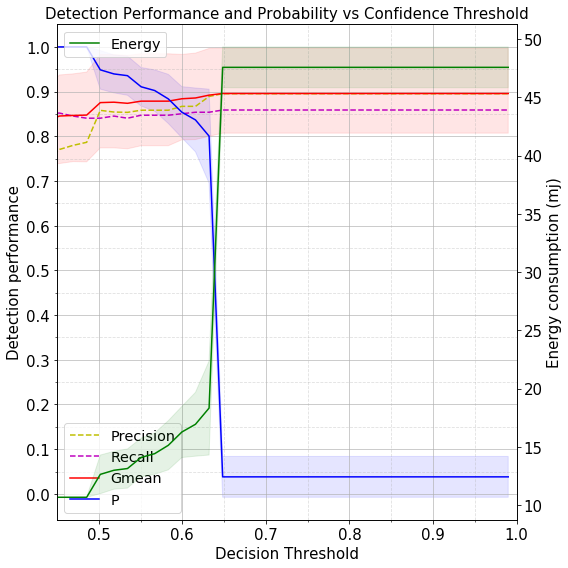

In [116]:
import matplotlib.ticker as mtick
plt.figure(figsize=(8, 8))
plt.xlim(0.45,1)
plt.title("Detection Performance and Probability vs Confidence Threshold", fontsize=15)
plt.plot(thresholds, mean_p, "y--", label="Precision")
plt.plot(thresholds, mean_r, "m--", label="Recall")
# plt.plot(thresholds, mean_acc, "r-", label="Accuracy")
# plt.plot(thresholds, mean_f1, "y-", label="F1")
plt.plot(thresholds, mean_gm, "r-", label="Gmean")
plt.plot(thresholds, mean_pp, "b-", label="P")
# plt.plot(thresholds, mean_acc3, "g-", label="Acc3")
# plt.plot(thresholds, mean_acc5, "y-", label="Accu5")


plt.ylabel("Detection performance",size = 15)
plt.xlabel("Decision Threshold",size = 15)
major_ticks = np.arange(0, 1.05, 0.1)
minor_ticks = np.arange(0, 1, 0.05)
major_ticksx = np.arange(0.5, 1.05, 0.1)
minor_ticksx = np.arange(0.5, 1, 0.05)
plt.gca().set_yticks(major_ticks)
plt.gca().set_yticks(minor_ticks, minor=True)
plt.gca().set_xticks(major_ticksx)
plt.gca().set_xticks(minor_ticksx, minor=True)
plt.grid(which='major',linestyle='-', alpha=0.8) # which = 'both'
plt.grid(which='minor',linestyle='--', alpha=0.4)
plt.legend(loc='best', fontsize= 'x-large')
plt.fill_between(thresholds, mean_pp - std_pp,mean_pp + std_pp, alpha=0.1, color="b")
# plt.fill_between(thresholds, mean_p - std_p, mean_p + std_p, alpha=0.1, color="b")
# plt.fill_between(thresholds, mean_r - std_r, mean_r + std_r, alpha=0.1, color="g")
plt.fill_between(thresholds, mean_acc - std_acc, mean_acc + std_acc, alpha=0.1, color="r")
plt.xticks(size = 15)
plt.yticks(size = 15)
ax2 = plt.gca().twinx()
ax2.set_ylabel('Energy consumption (mj)',size = 15)
ax2.plot(thresholds, mean_e, "g-", label="Energy")
ax2.fill_between(thresholds, mean_e - std_e, mean_e + std_e, alpha=0.1, color="g")
ax2.legend(loc='upper left', fontsize= 'x-large')
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.tight_layout()
# plt.savefig("selfawaress_1_3_d1_th0.6.pdf")
# plt.savefig("selfawaress_1_3_5_d1_th0.6.png")
plt.show()

In [117]:
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

precision_recall = mean_pp, mean_gm, mean_r,mean_p, thresholds 
precision_recall = pd.DataFrame(precision_recall).T
precision_recall.columns = ['P','Gmean', 'Recall', 'Precision','Thresholds']
precision_recall.iplot(x='Thresholds', xTitle='Decision Threshold',yTitle='Score', title='Precision/Recall Tradeoff')

In [121]:
f1s = []
ps =[]
rs =[]
accs = []
accs3 = []
accs4 = []
accs5 = []
accs1 = []
accs2 = []
p_1s =[]
p_3s =[]
pps = []
gms =[]
spes =[]
es =[]
thresholds = np.linspace(0.03, 0.99, 60)
for i, (train_index, val_index) in enumerate(cv.split(X_train5, y_train, train_subjects)):
    X_train_tr5, X_val5 = X_train5.iloc[train_index,:], X_train5.iloc[val_index,:]
    X_train_tr4, X_val4 = X_train4.iloc[train_index,:], X_train4.iloc[val_index,:]
    X_train_tr3, X_val3 = X_train3.iloc[train_index,:], X_train3.iloc[val_index,:]
    X_train_tr2, X_val2 = X_train2.iloc[train_index,:], X_train2.iloc[val_index,:]
    X_train_tr1, X_val1 = X_train1.iloc[train_index,:], X_train1.iloc[val_index,:]
    y_train_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    modelxgb5.fit(X_train_tr5, y_train_tr)
    modelxgb4.fit(X_train_tr4, y_train_tr)
    modelxgb3.fit(X_train_tr3, y_train_tr)
    modelxgb2.fit(X_train_tr2, y_train_tr)
    modelxgb1.fit(X_train_tr1, y_train_tr)
    proba_xgb5 = modelxgb5.predict_proba(X_val5)[:, 1]
    proba_xgb4 = modelxgb4.predict_proba(X_val4)[:, 1]
    pred_xgb4 = modelxgb4.predict(X_val4)
    proba_xgb3 = modelxgb3.predict_proba(X_val3)[:, 1]
    pred_xgb3 = modelxgb3.predict(X_val3)
    proba_xgb2 = modelxgb2.predict_proba(X_val2)[:, 1]
    pred_xgb2 = modelxgb2.predict(X_val2)
    proba_xgb1 = modelxgb1.predict_proba(X_val1)[:, 1]
    pred_xgb1 = modelxgb1.predict(X_val1)
    f1 = np.ones(len(thresholds))
    acc = np.ones(len(thresholds))
    p = np.ones(len(thresholds))
    r = np.ones(len(thresholds))
    y_pred_adj= np.ones(len(proba_xgb4))
    acc1 = np.ones(len(thresholds))
    acc4 = np.ones(len(thresholds))
    gm = np.ones(len(thresholds))
    spe = np.ones(len(thresholds))
    e = np.ones(len(thresholds))
    p_1_percent = np.ones(len(thresholds))
    p_3_percent = np.ones(len(thresholds))
    p_percent = np.ones(len(thresholds))
    for jj in range(len(thresholds)):
        th = thresholds[jj] 
        n = len(proba_xgb5)
        p_1 = 0
        p_3_1 = 0
        p_3_2 = 0
        for i in range(len(proba_xgb5)): 
            if proba_xgb5[i] >0.6:
                y_pred_adj[i] = 1
            elif proba_xgb5[i] <=1-0.6:
                y_pred_adj[i] = 0
            elif proba_xgb3[i] >th:
                p_3_1 = p_3_1 +1
                y_pred_adj[i] = 1
            elif proba_xgb3[i] <=1-th:
                p_3_2 = p_3_2 +1
                y_pred_adj[i] = 0
            else:
                p_1 = p_1 + 1
                y_pred_adj[i]= pred_xgb1[i]
        p_3_percent[jj] = (p_3_1+p_3_2)/n
        p_1_percent[jj] = p_1/n
        p_percent[jj] = 1-p_1_percent[jj]
        # y_pred_adj = adjusted_classes(proba_xgb, t=th)
        acc[jj] = accuracy_score(y_val, y_pred_adj)
        f1[jj] = fbeta_score(y_val, y_pred_adj, beta=1)
        p[jj] = precision_score(y_val, y_pred_adj)
        r[jj] = recall_score(y_val, y_pred_adj)
        gm[jj] = geometric_mean_score(y_val, y_pred_adj)
        spe[jj] = specificity_score(y_val, y_pred_adj)
        # y_pred_adj4 = adjusted_classes(proba_xgb4, t=th)
        # y_pred_adj1 = adjusted_classes(proba_xgb1, t=th)
        # acc4[jj] = accuracy_score(y_val, y_pred_adj4)
        # acc1[jj] = accuracy_score(y_val, y_pred_adj1)
        # acc3[jj] = accuracy_score(y_val, pred_xgb3)
        e[jj] = 10.68 +(1-p_percent[jj])*38.35
    
    f1s.append(f1)
    ps.append(p)
    rs.append(r)
    accs.append(acc)
    # accs1.append(acc1)
    # accs4.append(acc4)
    p_1s.append(p_1_percent)
    p_3s.append(p_3_percent)
    pps.append(p_percent)
    gms.append(gm)
    spes.append(spe)
    es.append(e)

mean_f1 = np.mean(f1s, axis =0)
mean_p = np.mean(ps, axis =0)
mean_r = np.mean(rs, axis =0)
mean_acc = np.mean(accs, axis =0)
# mean_acc4 = np.mean(accs4, axis =0)
# mean_acc1 = np.mean(accs1, axis =0)
mean_p_1 = np.mean(p_1s, axis =0)
mean_pp = np.mean(pps, axis =0)
mean_p_3 = np.mean(p_3s, axis =0)
mean_gm = np.mean(gms, axis=0)
mean_spe = np.mean(spes, axis=0)
mean_e = np.mean(es, axis=0)

std_f1 = np.std(f1s, axis =0)
std_p = np.std(ps, axis =0)
std_r = np.std(rs, axis =0)
std_acc = np.std(accs, axis =0)
# std_acc1 = np.std(accs1, axis =0)
# std_acc4 = np.std(accs4, axis =0)
std_p_1 = np.std(p_1s, axis =0)
std_pp = np.std(pps, axis =0)
std_gm = np.std(gms, axis =0)
std_spe = np.std(spes, axis =0)
std_e = np.std(es, axis =0)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=1, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=56, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=41, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

<Figure size 600x400 with 0 Axes>

Text(0.5, 1.0, 'Performance vs Energy')

(0, 55)

(0.4, 1)

Text(0.5, 0, '$Energy (mJ)$')

Text(0, 0.5, '$Scores$')

[<matplotlib.axis.XTick at 0x18ea57d1288>,
 <matplotlib.axis.XTick at 0x18ea57ec208>,
 <matplotlib.axis.XTick at 0x18ea57ece88>,
 <matplotlib.axis.XTick at 0x18ea586c888>,
 <matplotlib.axis.XTick at 0x18ea5801b48>,
 <matplotlib.axis.XTick at 0x18ea6e7b9c8>]

[<matplotlib.axis.XTick at 0x18ea67d9608>,
 <matplotlib.axis.XTick at 0x18ea57d5a48>,
 <matplotlib.axis.XTick at 0x18ea5851d88>,
 <matplotlib.axis.XTick at 0x18ea67c5908>,
 <matplotlib.axis.XTick at 0x18ea57e8bc8>,
 <matplotlib.axis.XTick at 0x18ea6dc1e08>,
 <matplotlib.axis.XTick at 0x18ea58f3048>,
 <matplotlib.axis.XTick at 0x18ea586c848>,
 <matplotlib.axis.XTick at 0x18ea58e9748>,
 <matplotlib.axis.XTick at 0x18ea58e9348>,
 <matplotlib.axis.XTick at 0x18ea6e73088>,
 <matplotlib.axis.XTick at 0x18ea58e9188>,
 <matplotlib.axis.XTick at 0x18ea58f3bc8>,
 <matplotlib.axis.XTick at 0x18ea57d7608>,
 <matplotlib.axis.XTick at 0x18ea57d6948>,
 <matplotlib.axis.XTick at 0x18ea67a34c8>,
 <matplotlib.axis.XTick at 0x18ea58e6448>,
 <matplotlib.axis.XTick at 0x18ea6de7748>,
 <matplotlib.axis.XTick at 0x18ea6c0d408>,
 <matplotlib.axis.XTick at 0x18ea5887ac8>,
 <matplotlib.axis.XTick at 0x18ea585db88>,
 <matplotlib.axis.XTick at 0x18ea6c0d0c8>,
 <matplotlib.axis.XTick at 0x18ea57d6a08>,
 <matplotlib.axis.XTick at 0x18ea587bfc8>,
 <matplotlib.axis.XTick at 0x18ea5884448>,
 <matplotlib.axis.XTick at 0x18ea5858708>,
 <matplotlib.axis.XTick at 0x18ea587f208>,
 <matplotlib.axis.XTick at 0x18ea587f608>]

c:\users\niloo\desktop\project2019_20\venv3701\lib\site-packages\ipykernel_launcher.py:24: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.

c:\users\niloo\desktop\project2019_20\venv3701\lib\site-packages\ipykernel_launcher.py:25: UserWarning:

In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.



<StemContainer object of 3 artists>

<StemContainer object of 3 artists>

Text(46, 0.93, 'ECG,PPG,RSP,EDA')

Text(28, 0.89, 'ECG,RSP,EDA')

Text(12, 0.95, 'ECG, EDA')

Text(7.2, 0.87, 'ECG')

Text(5.3, 0.94, 'S')

Text(3.7, 0.68, 'EDA')

[<matplotlib.axis.XTick at 0x18ea58129c8>,
 <matplotlib.axis.XTick at 0x18ea5b96bc8>,
 <matplotlib.axis.XTick at 0x18ea5b96988>,
 <matplotlib.axis.XTick at 0x18ea582b7c8>,
 <matplotlib.axis.XTick at 0x18ea58311c8>,
 <matplotlib.axis.XTick at 0x18ea5831b48>]

[Text(0, 1, '1'),
 Text(0, 1, '2'),
 Text(0, 1, '3'),
 Text(0, 1, '4'),
 Text(0, 1, 'S'),
 Text(0, 1, '5')]

Text(0.5, 0, 'Mode')

(0, 55)

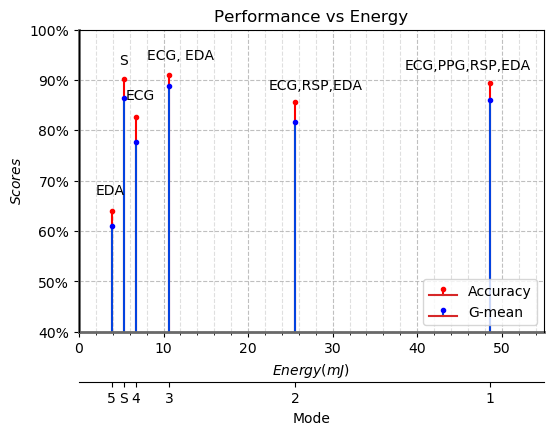

In [129]:
import matplotlib.ticker as mtick

eng = [48.6, 25.57, 10.67, 6.76, 5.3, 3.86]
n = [10, 16,10,31,11,14,8,1,17,28]
plt.figure(figsize=(6,4), dpi= 100)

plt.title('Performance vs Energy', fontdict={'size':12})
plt.xlim(0,55)
plt.ylim(bottom =0.4, top=1)
#plt.yticks(fontsize=12, alpha=.7)
plt.xlabel('$Energy (mJ)$')
plt.ylabel('$Scores$')
# Major ticks every 10, minor ticks every 2
major_ticks = np.arange(0, 55, 10)
minor_ticks = np.arange(0, 55, 2)

plt.gca().set_xticks(major_ticks)
plt.gca().set_xticks(minor_ticks, minor=True)
# ax.set_yticks(major_ticks)
# ax.set_yticks(minor_ticks, minor=True)
test_acc = [0.89473684, 0.85714286, 0.90977444, 0.82706767,0.9023, 0.63909774]
test_gm = [0.86000709, 0.81672273, 0.8882115,  0.77780856,0.8648, 0.61016323]

plt.stem(eng, test_acc,label="Accuracy",markerfmt ="r.",linefmt='r')# ,linefmt='green'
plt.stem(eng, test_gm,label="G-mean",markerfmt ="b.",linefmt='xkcd:blue')

# for x, y, tex in zip (eng,tes_engh_acc, n):
#     k = plt.text(x,y,tex, horizontalalignment ='center',
#          verticalalignment ='center',color='white', fontsize=8,
#                  bbox=dict(facecolor='#2c6faa',edgecolor='azure', boxstyle='circle'))


# e1 = [51, 27.5, 12,7.5, 5.5]
# s1 = [0.887, 0.864, 0.872, 0.8271, 0.639]
# n1 =[1411, 855, 85, 3, 65]

# e2 =[50,46.3,43,31,29,27.5,24.4,8,5.2,2 ]
# s2 =[0.89, 0.90, 0.89, 0.915, 0.91, 0.90, 0.89, 0.73, 0.60, 0.50 ]
# n2 =[85,88,78,85,77,94,96,64,19,29]

# for x, y, tex in zip (e1,s1, n1):
#     k = plt.text(x,y,tex, horizontalalignment ='center',
#          verticalalignment ='center',color='b', fontsize=9)

# for x, y, tex in zip (e2,s2, n2):
#     k = plt.text(x,y,tex, horizontalalignment ='center',
#          verticalalignment ='center',color='r', fontsize=9)

plt.text(46,0.93,'ECG,PPG,RSP,EDA', ha = 'center', va = 'center')
plt.text(28,0.89,'ECG,RSP,EDA', ha = 'center', va = 'center')
plt.text(12,0.95,'ECG, EDA', ha = 'center', va = 'center')
plt.text(7.2,0.87,'ECG', ha = 'center', va = 'center')
plt.text(5.3,0.94,'S', ha = 'center', va = 'center')
plt.text(3.7,0.68,'EDA', ha = 'center', va = 'center')

plt.legend(loc='lower right')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().spines["left"].set_linewidth(2)
plt.gca().spines["left"].set_color("dimgray")
plt.gca().spines["bottom"].set_linewidth(2)
plt.gca().spines["bottom"].set_color("dimgray")
plt.grid(which='major',linestyle='--', alpha=0.8) # which = 'both'
plt.grid(which='minor',linestyle='--', alpha=0.4)

# Remove borders
plt.gca().spines["top"].set_alpha(0.0)    
#plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.0)    
#plt.gca().spines["left"].set_alpha(0.3)   

# Set scond x-axis
ax2 = plt.gca().twiny()

# Decide the ticklabel position in the new x-axis,
# then convert them to the position in the old x-axis
newlabel = [1,2,3,4,'S',5] # labels of the xticklabels: the position in the new x-axis
newpos   = [48.6, 25.57, 10.67, 6.76, 5.3, 3.86]   # position of the xticklabels in the old x-axis
ax2.set_xticks(newpos)
ax2.set_xticklabels(newlabel)

ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Mode')
ax2.set_xlim(0,55)

plt.savefig("perf_vs_eng_s36_self.pdf", bbox_inches = 'tight')
plt.savefig("perf_vs_eng_s36_self.png", bbox_inches = 'tight')
plt.show()



In [ ]:
x = ["ECG_RR_mean","SCL_mean","ECG_RR_SDSD","ECG_RR_LoT_2","RSP_Pk","SCL_std","RSP_ecgHF_pF2n","RSP_HF_gaussF1",
     "PPG_PP_CSI_modified","ECG_RR_Log10LT_2","RSP_HF","ECG_RR_L2","PPG_PRT_SDNN","ECG_RR_SDNN","RSP_Rate_std","ECG_RR_L"]
Signal = np.array([6.67,3.2,0,0,11.15,0,0,0,18.45,0,0,0,0,0,0,0])
Parameter = np.array([0,0.64,0,0.04,3.78, 0, 3.73, 0, 0.04, 0,0,0,0,0,0.75,0])
Feature = np.array([0, 0.02, 0,0,0,0,0.04,0.03,0,0,0.01,0,0,0,0,0])
y_pos = np.arange(len(x))
plt.figure(figsize=(8,6))


# stack bars
plt.barh(x, Signal, label='Signal')
plt.barh(x, Parameter ,left=Signal,label='Parameter')
plt.barh(x, Feature ,left=Signal+Parameter,label='Feature')

# add text annotation corresponding to the percentage of each data.
# for xpos, ypos, yval in zip(x, y1/2, y1):
#     plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
# for xpos, ypos, yval in zip(x, y1+y2/2, y2):
#     plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
# for xpos, ypos, yval in zip(x, y1+y2+y3/2, y3):
#     plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
# # add text annotation corresponding to the "total" value of each bar
# for xpos, ypos, yval in zip(x, y1+y2+y3, snum):
#     plt.text(xpos, ypos, "N=%d"%yval, ha="center", va="bottom")
plt.gca().invert_yaxis()
plt.xlim(0,20)
plt.xlabel("Energy-cost of selected features",size = 15)
plt.xticks(size = 12)
plt.xticks(size = 12)
# plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left')
plt.legend(loc='upper right')
plt.savefig('energy_cost.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


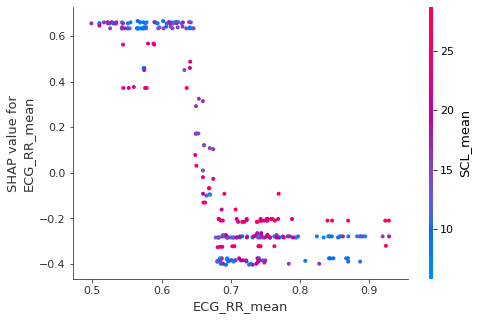

In [17]:
import shap
feat_list = final_features2[2][0]
x = X_train[feat_list]
xt = X_test[feat_list]
paramss = {
    'max_depth': 5, 
    'n_estimators': 1
     }
model = XGBClassifier(**paramss).fit(x, y_train)
# modelxgb.fit(X_train, y_train)
shap_values = shap.TreeExplainer(model).shap_values(x)
#shap.summary_plot(shap_values, X_train)
shap.dependence_plot("ECG_RR_mean", shap_values, x, interaction_index="SCL_mean" ,show=False)
# plt.ylim(bottom =-2.5, top=5)
# shap.dependence_plot("SCL_mean", shap_values, x, interaction_index="ECG_RR_mean" ,show=False)
# plt.savefig("shap_mode1_ylim2.png", bbox_inches = 'tight')
# plt.savefig("shap_mode1_ylim2.pdf", bbox_inches = 'tight')
# shap.summary_plot(shap_values, X_train, plot_type="bar",max_display=16,show=False)
plt.show()

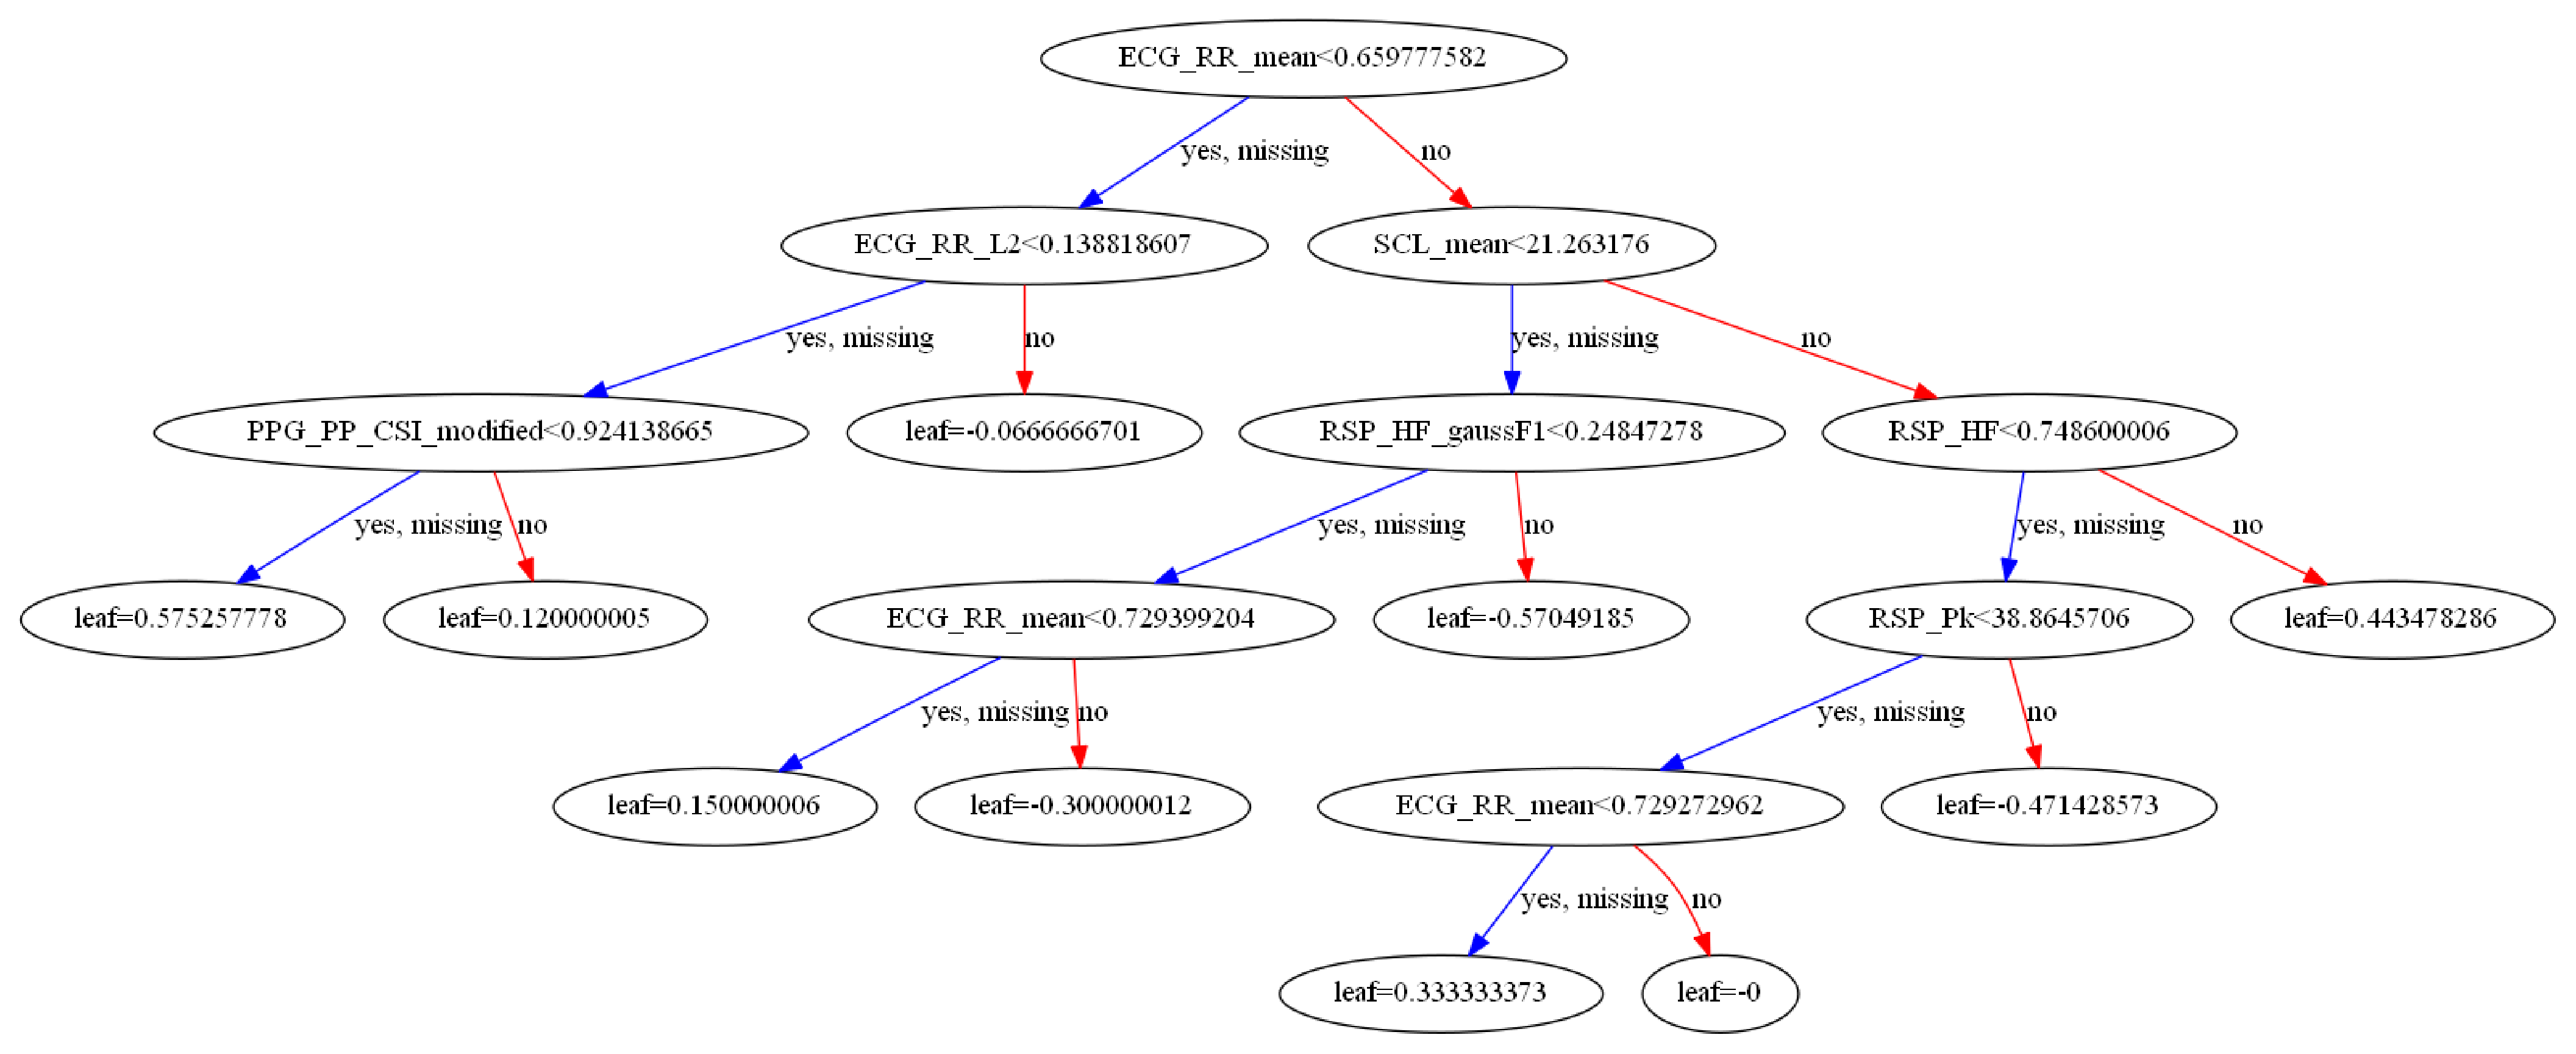

In [25]:
from xgboost import plot_tree
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 27,50
rcParams['figure.dpi'] = 200
rcParams['savefig.dpi'] = 200
feat_list = final_features2[0][0]
x = X_train[feat_list]
# xt = X_test[feat_list]
paramss = {
    'max_depth': 6, 
    'n_estimators': 41
     }
model = XGBClassifier(**paramss).fit(x, y_train)
plot_tree(model, num_trees=0)
plt.savefig('xgbtree_36_mode1.pdf', bbox_inches='tight')
plt.show()

c:\users\niloo\desktop\project2019_20\venv3701\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning:

divide by zero encountered in log10

c:\users\niloo\desktop\project2019_20\venv3701\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning:

divide by zero encountered in log10

c:\users\niloo\desktop\project2019_20\venv3701\lib\site-packages\matplotlib\axes\_axes.py:2179: RuntimeWarning:

invalid value encountered in double_scalars



<Figure size 576x432 with 0 Axes>

<BarContainer object of 16 artists>

<BarContainer object of 16 artists>

<BarContainer object of 16 artists>

(0, 10)

Text(0.5, 0, 'Energy-cost of selected features')

(array([ 0.,  2.,  4.,  6.,  8., 10.]), <a list of 6 Text xticklabel objects>)

(array([ 0.,  2.,  4.,  6.,  8., 10.]), <a list of 6 Text xticklabel objects>)

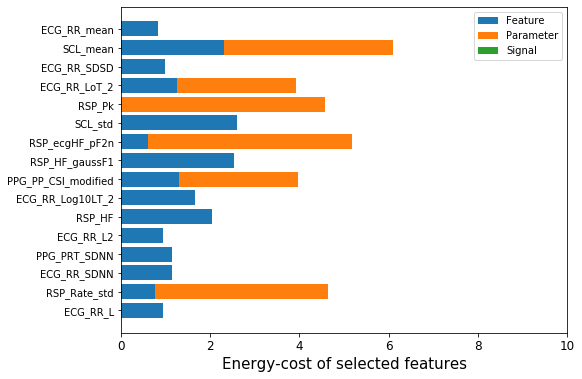

In [109]:
from numpy import inf
x = ["ECG_RR_mean","SCL_mean","ECG_RR_SDSD","ECG_RR_LoT_2","RSP_Pk","SCL_std","RSP_ecgHF_pF2n","RSP_HF_gaussF1",
     "PPG_PP_CSI_modified","ECG_RR_Log10LT_2","RSP_HF","ECG_RR_L2","PPG_PRT_SDNN","ECG_RR_SDNN","RSP_Rate_std","ECG_RR_L"]
Signal = np.array([6760,3200,0,0,11156.6,0,0,0,18452,0,0,0,0,0,0,0])
Parameter = np.array([0,640,0,45.3,3784, 0, 3738, 0, 45.3, 0,0,0,0,0,753.5,0])
Feature = np.array([0.69, 20, 0.96,1.85,0.1,40,0.4,33.73,2.06,4.51,10.91,0.88,1.39,1.39,0.58,0.88])

Signal = np.log10(Signal*10)
Parameter = np.log10(Parameter*10)
Feature = np.log10(Feature*10)
# y_pos = np.arange(len(x))
plt.figure(figsize=(8,6))


# stack bars
plt.barh(x, Feature, label='Feature')
plt.barh(x, Parameter ,left=Feature,label='Parameter')
plt.barh(x, Signal ,left=Feature+Parameter,label='Signal')

# add text annotation corresponding to the percentage of each data.
# for xpos, ypos, yval in zip(x, y1/2, y1):
#     plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
# for xpos, ypos, yval in zip(x, y1+y2/2, y2):
#     plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
# for xpos, ypos, yval in zip(x, y1+y2+y3/2, y3):
#     plt.text(xpos, ypos, "%.1f"%yval, ha="center", va="center")
# # add text annotation corresponding to the "total" value of each bar
# for xpos, ypos, yval in zip(x, y1+y2+y3, snum):
#     plt.text(xpos, ypos, "N=%d"%yval, ha="center", va="bottom")
plt.gca().invert_yaxis()
plt.xlim(0,10)
plt.xlabel("Energy-cost of selected features",size = 15)
plt.xticks(size = 12)
plt.xticks(size = 12)
# plt.legend(bbox_to_anchor=(1.01,0.5), loc='center left')
plt.legend(loc='upper right')
# plt.savefig('energy_cost.pdf', bbox_inches='tight', pad_inches=0.02)
plt.show()

